# VGG16 Transfer Learned + SVM  (NO-PCA and PCA)

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [2]:
## extra imports to set GPU options
import tensorflow as tf
from keras import backend as k

###################################
# TensorFlow wizardry
config = tf.ConfigProto()

# Don't pre-allocate memory; allocate as-needed
config.gpu_options.allow_growth = True

# Only allow a total of half the GPU memory to be allocated
config.gpu_options.per_process_gpu_memory_fraction = 1 # 0.5 for Half

# Create a session with the above options specified.
k.tensorflow_backend.set_session(tf.Session(config=config))


Using TensorFlow backend.


In [2]:
import os
import os.path
import glob
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import Activation
from keras.layers import Dense, Flatten
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import *
from keras.models import Sequential
from keras.layers.core import Flatten, Dense, Dropout
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.optimizers import SGD
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
from keras.utils import plot_model
import numpy
import tensorflow as tf
import keras
import time

import seaborn as sns
import pandas as pd
import numpy as np
import linecache
import sys
import h5py
import itertools
import matplotlib.pyplot as plt
import pickle
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint
from keras.callbacks import TensorBoard
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import EarlyStopping
from keras.callbacks import RemoteMonitor
from numpy import argmax
import numpy as np
from numpy.random import RandomState
np.random.seed(1)
from tsne import bh_sne
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold                                                                                                                       
from sklearn.metrics import confusion_matrix,accuracy_score
from sklearn import svm
from keras.preprocessing import image
from keras.applications.vgg16 import VGG16
from keras.applications.imagenet_utils import preprocess_input
import matplotlib.pyplot as plt
import matplotlib.cm as colormap
plt.rcParams['image.cmap'] = 'Paired'
import numpy as np
np.random.seed(1)
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.utils import np_utils
#from PIL import Image
from keras.preprocessing import image
from keras.applications.vgg19 import VGG19
from keras.applications.vgg16 import VGG16
from keras.applications.imagenet_utils import preprocess_input
from PIL import Image
import time


Using TensorFlow backend.


In [4]:
tf.__version__

'1.9.0'

In [5]:
tic = time.time();

X = np.load("DatasetX.npy")
y = np.load("Datasety.npy")
print(X.shape)
print(y.shape)

file = open('list_fams.pkl', 'rb')
list_fams = pickle.load(file)
file.close()
len(list_fams)


toc = time.time();
print ("Elasped Time (s) = ", toc-tic);


(9339, 224, 224, 3)
(9339,)
Elasped Time (s) =  8.196847915649414


In [8]:
model = keras.applications.vgg16.VGG16(include_top=True, weights='imagenet', input_shape=(224,224,3), classes=1000)
#model.summary()

In [9]:
transfer_layer = model.get_layer('fc2')
conv_model = Model(inputs=model.input,
                   outputs=transfer_layer.output)
#conv_model.summary()

In [10]:
tic = time.time();


filename = 'VGG16-TL-Features.npy'
if os.path.exists(filename):
    print("Loading VGG16 extracted features from %s ..." %(filename))
    vgg16features = np.load(filename)
else:
    print("Extracting features from VGG16 layers ...")
    vgg16features = conv_model.predict(X)
    print("Saving VGG16 extracted features into %s ..." %(filename))
    np.save(filename, vgg16features)
    
print(vgg16features.shape)


toc = time.time();
print ("Elasped Time (s) = ", toc-tic);


Extracting features from VGG16 layers ...
Saving VGG16 extracted features into VGG16-TL-Features.npy ...
(9339, 4096)
Elasped Time (s) =  40.56252598762512


# VGG16 Transfer Learned No-PCA Applied

In [11]:
tic = time.time();


from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(vgg16features, y, test_size=0.301, random_state=42)

toc = time.time();
print ("Elasped Time (s) = ", toc-tic);

Elasped Time (s) =  0.10390996932983398


In [12]:
tic = time.time();


top_model = svm.LinearSVC(C=0.01)
top_model.fit(X_train,y_train)  # Training
y_pred = top_model.predict(X_test)  # Testing
print("Test acurracy: %.4f" %(accuracy_score(y_test,y_pred)))

toc = time.time();
print ("Elasped Time (s) = ", toc-tic);

/home/danish/anaconda3/envs/tf/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Test acurracy: 0.9566
Elasped Time (s) =  34.307841062545776


In [13]:
file = open('VGG16-TL-SVM(pred).pkl', 'wb')
pickle.dump(y_pred, file)
file.close()

In [14]:
# read Traning History back from the file
file = open('VGG16-TL-SVM(pred).pkl', 'rb')
y_pred = pickle.load(file)
print("Test acurracy: %.4f" %(accuracy_score(y_test,y_pred)))
file.close()

Test acurracy: 0.9566


In [15]:
from pycm import ConfusionMatrix
CM_VGG16_TL_SVM = ConfusionMatrix(y_test,y_pred)
file = open('CM_VGG16_TL_SVM.pkl', 'wb')
pickle.dump(CM_VGG16_TL_SVM, file)
file.close()

In [3]:
# write Traning History to a file
file = open('CM_VGG16_TL_SVM.pkl', 'rb')
CM_VGG16_TL_SVM = pickle.load(file)
file.close()

# ROC Curve for VGG16-TL+SVM

In [17]:
from numpy import array
from numpy import argmax
from keras.utils import to_categorical
# define example
#y_pred = cls_pred

# one hot encode
Y_pred = to_categorical(y_pred)
print(Y_pred.shape)
# invert encoding
#inverted = argmax(encoded[0])
#print(inverted)


from numpy import array
from numpy import argmax
from keras.utils import to_categorical
# define example
#y_test = cls_test

# one hot encode
Y_test = to_categorical(y_test)
print(Y_test.shape)
# invert encoding
#inverted = argmax(encoded[0])
#print(inverted)

(2812, 25)
(2812, 25)


In [22]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(25):
    fpr[i], tpr[i], _ = roc_curve(Y_test[:, i], Y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    #print("False-Positive-Rate",argmax(fpr[i],axis=1))
    #print("True-Positive-Rate",argmax(tpr[i],axis=1))
    #print("ROC_AUC",argmax(roc_auc[i],axis=0))

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(Y_test.ravel(), Y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

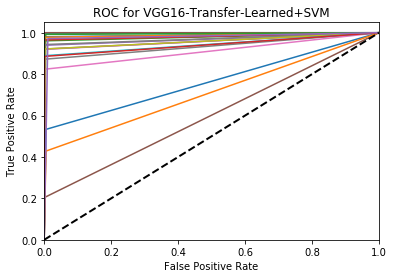

In [24]:
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(25)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(25):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= 25

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])


# Plot all ROC curves
#plt.figure()
#plt.figure(figsize = (25,9))

#plt.plot(fpr["micro"], tpr["micro"],
#         label='micro-average ROC curve (area = {0:0.2f})'
#               ''.format(roc_auc["micro"]),
#         color='deeppink', marker=11, linewidth=1)

#plt.plot(fpr["macro"], tpr["macro"],
#         label='macro-average ROC curve (area = {0:0.2f})'
#               ''.format(roc_auc["macro"]),
#         color='navy', marker=5, linewidth=1)


colormap = plt.cm.gist_ncar #nipy_spectral, Set1,Paired  
colorst = [colormap(i) for i in np.linspace(0, 0.9,25)]  

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(25), colors):
    plt.plot(fpr[i], tpr[i], 
             label='ROC curve of Family {0} (area = {1:0.2f})'
             ''.format(list_fams[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for VGG16-Transfer-Learned+SVM')
#plt.legend(loc="lower right", fontsize='small')
plt.savefig('ROC for Multi-class.png', transparent=True)
plt.show()

In [25]:
from sklearn.metrics import classification_report, confusion_matrix  
#print(confusion_matrix(cls_test,cls_pred))  
print(classification_report(y_test,y_pred,target_names=list_fams)) 

                precision    recall  f1-score   support

     Adialer.C       1.00      0.98      0.99        51
     Agent.FYI       1.00      1.00      1.00        34
     Allaple.A       0.99      1.00      0.99       903
     Allaple.L       1.00      1.00      1.00       459
 Alueron.gen!J       0.98      0.94      0.96        66
     Autorun.K       0.47      0.21      0.29        34
   C2LOP.gen!g       0.85      0.92      0.88        50
       C2LOP.P       0.84      0.87      0.85        47
Dialplatform.B       1.00      0.97      0.98        60
     Dontovo.A       1.00      1.00      1.00        50
      Fakerean       0.99      1.00      1.00       104
 Instantaccess       0.96      0.98      0.97       137
    Lolyda.AA1       0.96      0.96      0.96        51
    Lolyda.AA2       1.00      0.96      0.98        57
    Lolyda.AA3       0.95      0.92      0.93        38
     Lolyda.AT       0.90      1.00      0.95        38
   Malex.gen!J       0.93      0.82      0.87  

Plotting the confusion matrix normalized


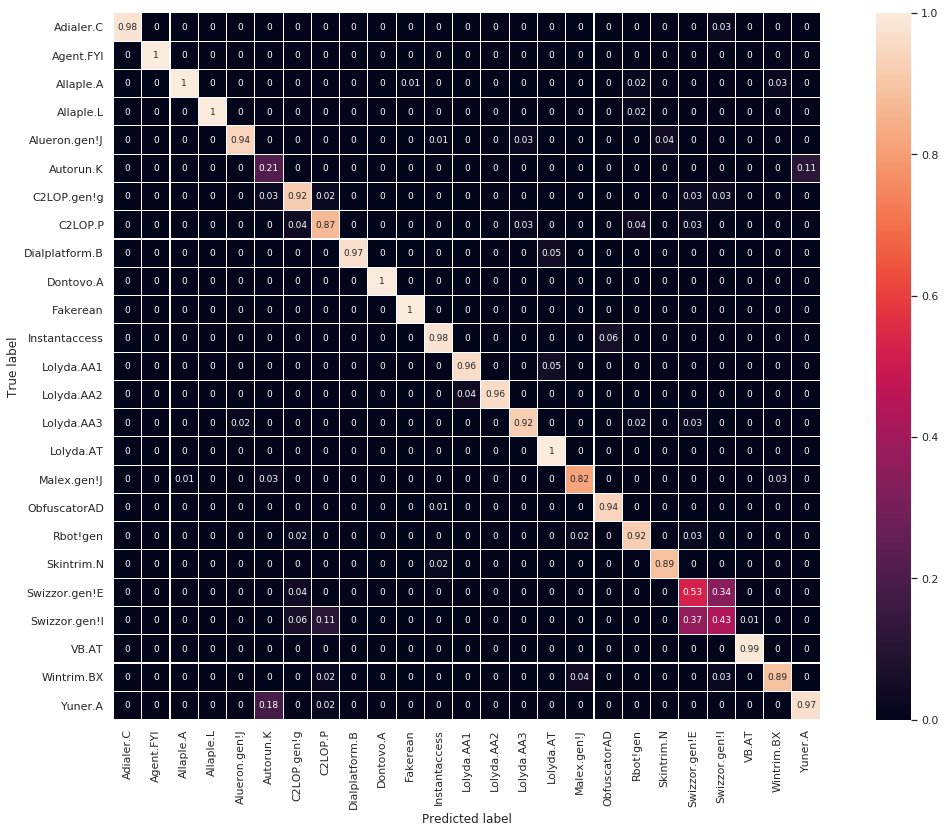

In [26]:
import seaborn as sns


conf_mat = confusion_matrix(y_test,y_pred)  # Compute confusion matrix 


print("Plotting the confusion matrix normalized")
conf_mat_norm = conf_mat/np.sum(conf_mat,axis=1)  # Normalizing the confusion matrix
conf_mat_norm = np.around(conf_mat_norm,decimals=2)  # rounding to display in figure

figure = plt.gcf()
figure.set_size_inches(20, 13)
sns.set(font_scale=1)
hm = sns.heatmap(conf_mat_norm, cbar=True, annot=True, square=True,
                 annot_kws={'size': 9}, linewidth = 0.1,
                 yticklabels=list_fams, xticklabels=list_fams)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [4]:
CM_VGG16_TL_SVM.F1

{0.0: 0.9900990099009901,
 1.0: 1.0,
 2.0: 0.9933774834437086,
 3.0: 0.9978213507625272,
 4.0: 0.9612403100775194,
 5.0: 0.2857142857142857,
 6.0: 0.8846153846153846,
 7.0: 0.8541666666666666,
 8.0: 0.9830508474576272,
 9.0: 1.0,
 10.0: 0.9952153110047847,
 11.0: 0.9675090252707581,
 12.0: 0.9607843137254902,
 13.0: 0.9821428571428571,
 14.0: 0.9333333333333333,
 15.0: 0.95,
 16.0: 0.875,
 17.0: 0.9428571428571428,
 18.0: 0.912621359223301,
 19.0: 0.9230769230769231,
 20.0: 0.5245901639344263,
 21.0: 0.46153846153846156,
 22.0: 0.991869918699187,
 23.0: 0.9117647058823529,
 24.0: 0.9317738791423001}

# VGG16 Transfer Learned PCA Applied